In [1]:
## import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

from mlxtend.plotting import plot_confusion_matrix

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score


In [4]:
## load the data
dfUnsupervisedML = pd.read_csv("customers.csv")
dfUnsupervisedML

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6
...,...,...,...,...,...,...,...,...,...,...
2622,467954,Male,No,29,No,Healthcare,9.0,Low,4.0,Cat_6
2623,467958,Female,No,35,Yes,Doctor,1.0,Low,1.0,Cat_6
2624,467960,Female,No,53,Yes,Entertainment,NaN,Low,2.0,Cat_6
2625,467961,Male,Yes,47,Yes,Executive,1.0,High,5.0,Cat_4


In [5]:
dfUnsupervisedML.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               2627 non-null   int64  
 1   Gender           2627 non-null   object 
 2   Ever_Married     2577 non-null   object 
 3   Age              2627 non-null   int64  
 4   Graduated        2603 non-null   object 
 5   Profession       2589 non-null   object 
 6   Work_Experience  2358 non-null   float64
 7   Spending_Score   2627 non-null   object 
 8   Family_Size      2514 non-null   float64
 9   Var_1            2595 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 205.4+ KB


Need to encode gender, ever_married, graduated, profession, spending_score, var_1

In [6]:
dfUnsupervisedML.describe()

,ID,Age,Work_Experience,Family_Size
count,2627.000000,2627.000000,2358.000000,2514.000000
mean,463433.918919,43.649791,2.552587,2.825378
std,2618.245698,16.967015,3.341094,1.551906
min,458989.000000,18.000000,0.000000,1.000000
25%,461162.500000,30.000000,0.000000,2.000000
50%,463379.000000,41.000000,1.000000,2.000000
75%,465696.000000,53.000000,4.000000,4.000000
max,467968.000000,89.000000,14.000000,9.000000


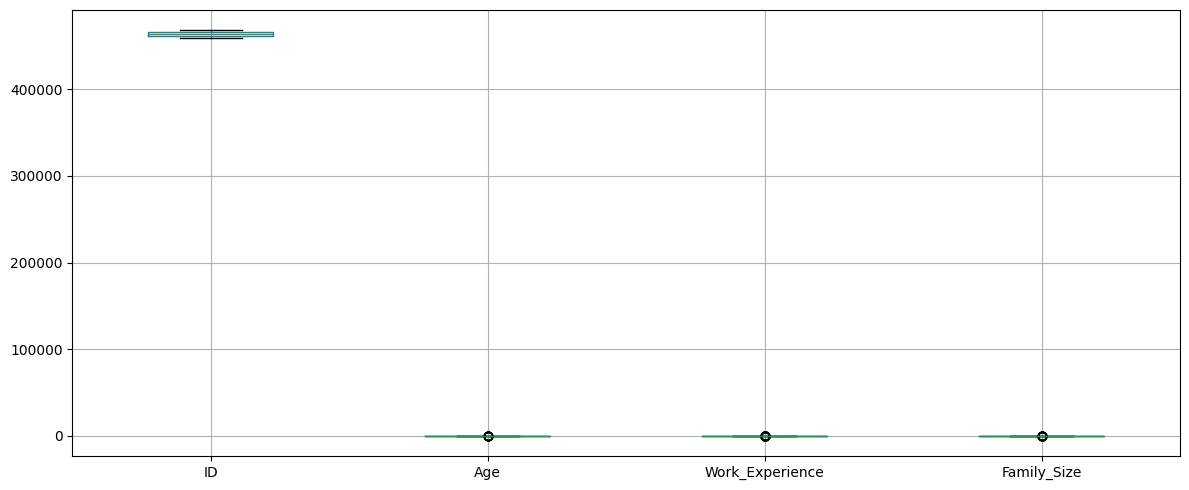

In [7]:
dfUnsupervisedML.boxplot(figsize=(12,5))
plt.tight_layout()

plt.show()

In [8]:
## Dropping ID as it's unique and irrelevant
dfUnsupervisedML_clean1 = dfUnsupervisedML.drop('ID',axis=1)
## Dropping Var_1 as it's synthetic
dfUnsupervisedML_clean1 = dfUnsupervisedML_clean1.drop('Var_1',axis=1)
dfUnsupervisedML_clean1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           2627 non-null   object 
 1   Ever_Married     2577 non-null   object 
 2   Age              2627 non-null   int64  
 3   Graduated        2603 non-null   object 
 4   Profession       2589 non-null   object 
 5   Work_Experience  2358 non-null   float64
 6   Spending_Score   2627 non-null   object 
 7   Family_Size      2514 non-null   float64
dtypes: float64(2), int64(1), object(5)
memory usage: 164.3+ KB


In [9]:
# check for duplicates
uniquetrainentries = dfUnsupervisedML_clean1.drop_duplicates()
uniquetrainentries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2474 entries, 0 to 2626
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           2474 non-null   object 
 1   Ever_Married     2424 non-null   object 
 2   Age              2474 non-null   int64  
 3   Graduated        2450 non-null   object 
 4   Profession       2436 non-null   object 
 5   Work_Experience  2214 non-null   float64
 6   Spending_Score   2474 non-null   object 
 7   Family_Size      2361 non-null   float64
dtypes: float64(2), int64(1), object(5)
memory usage: 174.0+ KB


There are duplicates when ID and Var_1 are removed, but I doubt they're the same person twice as everyone had a unique ID


In [10]:
dfUnsupervisedML_clean1.isnull().sum()

Gender               0
Ever_Married        50
Age                  0
Graduated           24
Profession          38
Work_Experience    269
Spending_Score       0
Family_Size        113
dtype: int64

Will need to have a look at the nulls in the object columns to understand how to replace them
Need to check curves to see distribution of other entries in numeric columns

In [11]:
# Check numbers of types of string objects
for i in dfUnsupervisedML_clean1:
    data_type =  dfUnsupervisedML_clean1[i].dtype
    if data_type == "object":
        value_count = dfUnsupervisedML_clean1[i].value_counts()
        print("\n",value_count)


 Gender
Male      1424
Female    1203
Name: count, dtype: int64

 Ever_Married
Yes    1520
No     1057
Name: count, dtype: int64

 Graduated
Yes    1602
No     1001
Name: count, dtype: int64

 Profession
Artist           802
Healthcare       418
Entertainment    301
Doctor           242
Engineer         236
Lawyer           221
Executive        176
Marketing        111
Homemaker         82
Name: count, dtype: int64

 Spending_Score
Low        1616
Average     625
High        386
Name: count, dtype: int64


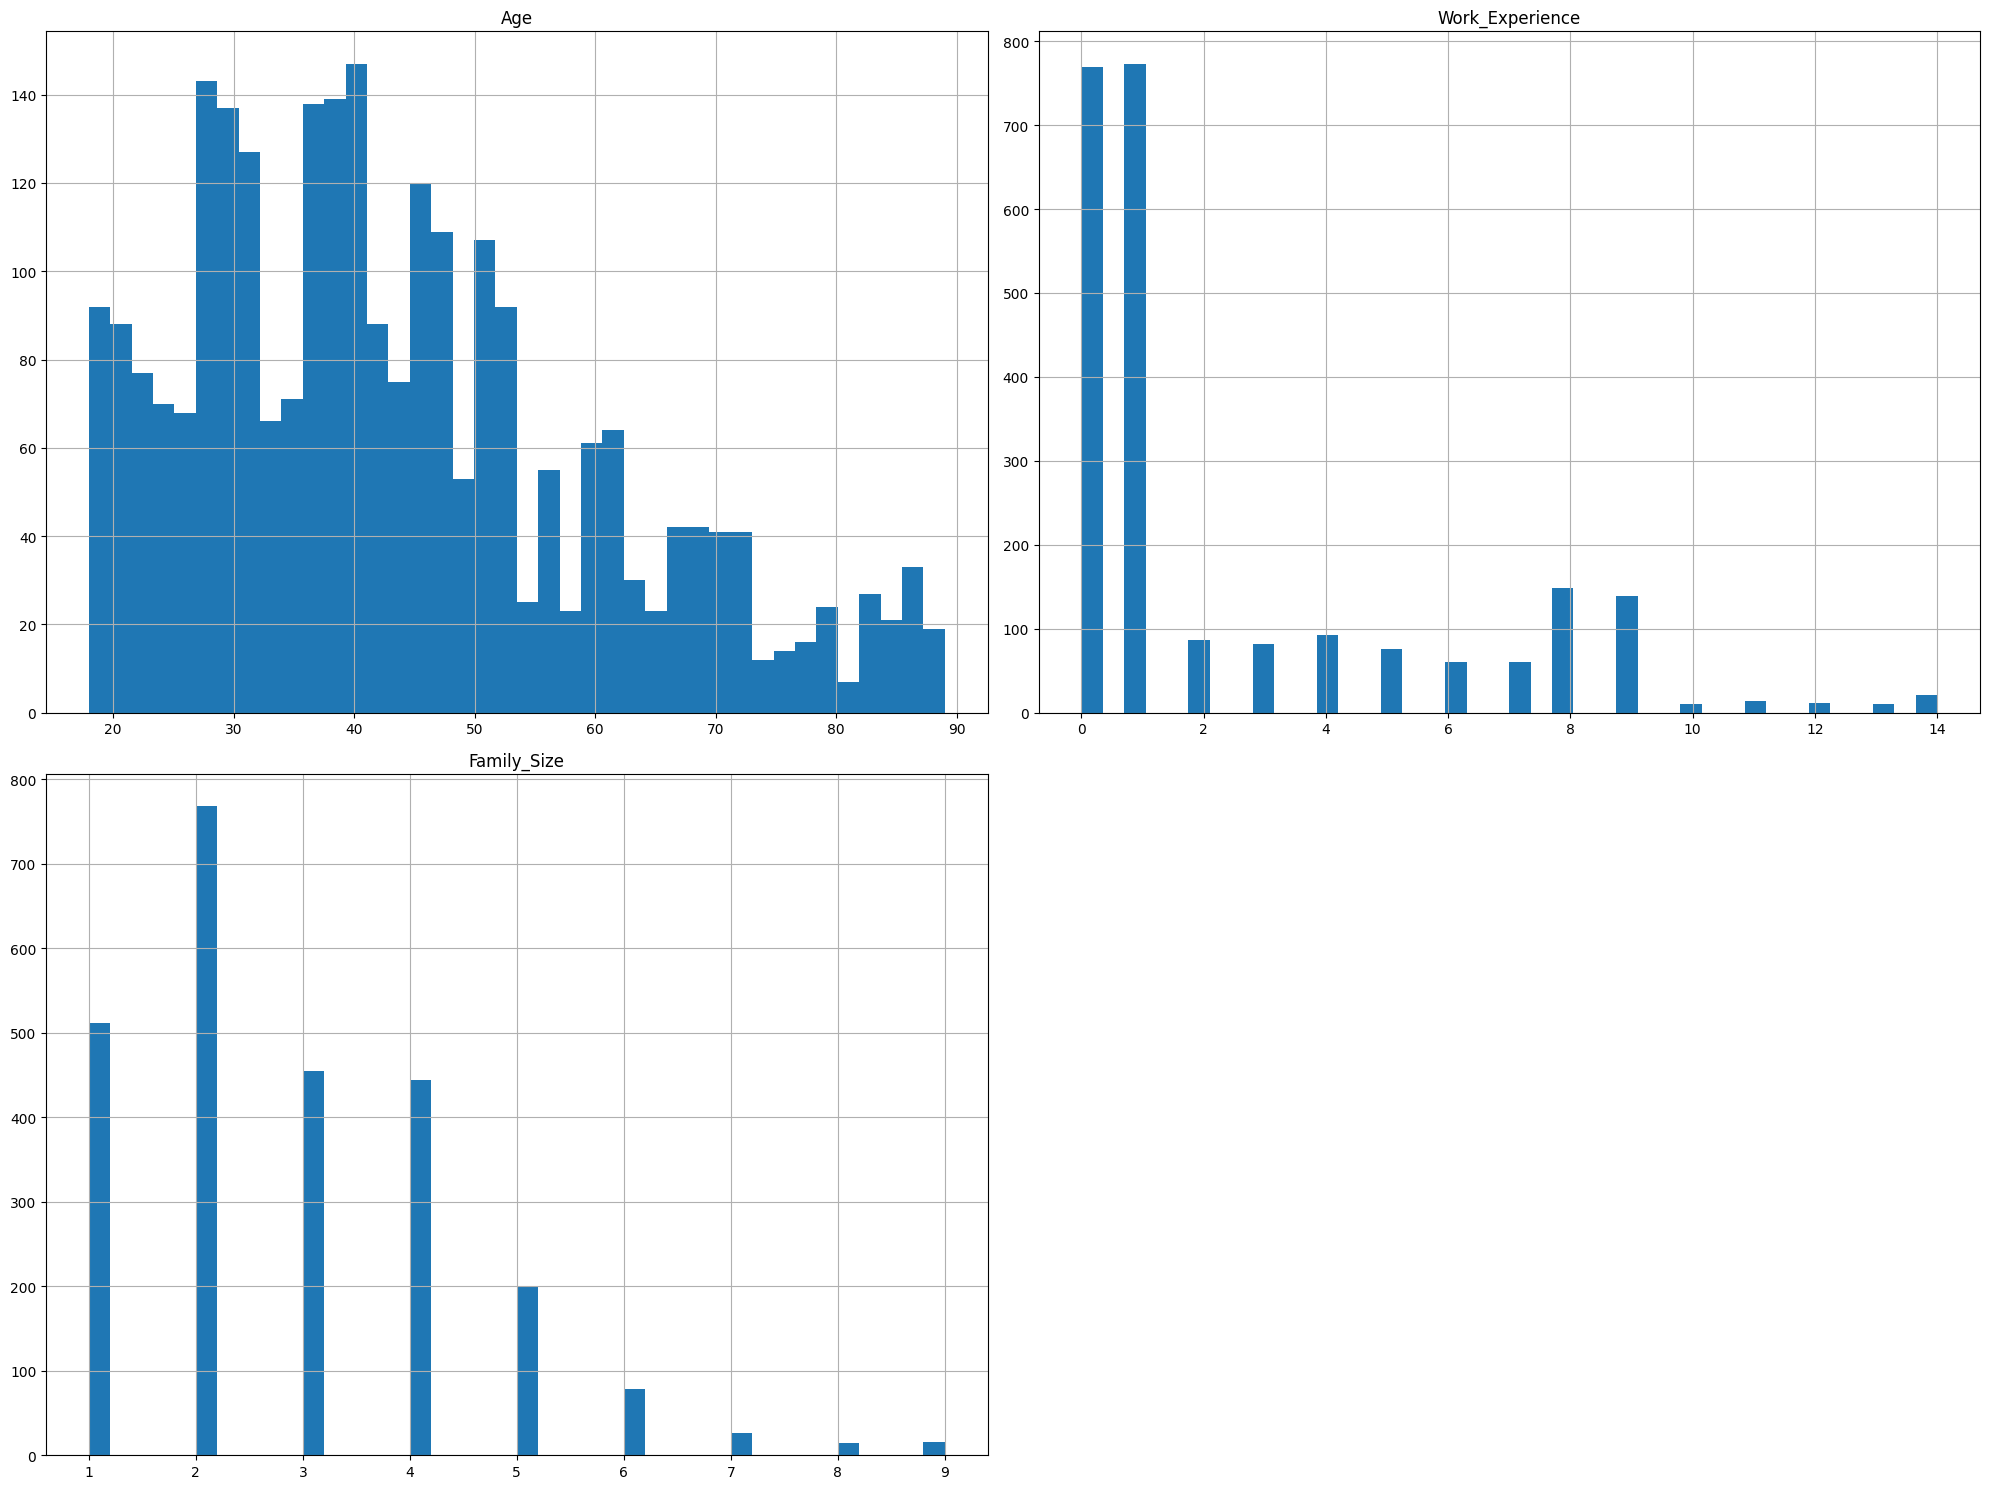

In [12]:
# histogram all numeric data
dfUnsupervisedML_clean1.hist(bins=40, figsize=(20, 15))
plt.tight_layout()

filename = 'histogram-raw.jpeg'
plt.savefig(filename, format = 'jpeg')

plt.show()

Lots of skew in the data. 

Replace null Family_Size and Work_Experience with the median.

Will simply drop null non-continuous variables Profession, Graduated and Ever_Married. 

Label Encode Gender, Ever_Married, Spending_Score and Graduated.

One hot encode Profession

#allvars = ['Gender','Ever_Married','Age','Graduated','Profession','Work_Experience','Spending_Score','Family_Size']
#dfUnsupervisedML_enc[allvars] = dfUnsupervisedML_enc[allvars].replace(0, np.nan)

In [13]:
# Clean the dataset
label_enc = LabelEncoder()

dfUnsupervisedML_enc = dfUnsupervisedML_clean1

## Fill in null Family Size, Work Experience with medians
dfUnsupervisedML_enc['Family_Size'] = dfUnsupervisedML_enc['Family_Size'].fillna(dfUnsupervisedML_enc['Family_Size'].median())
dfUnsupervisedML_enc['Work_Experience'] = dfUnsupervisedML_enc['Work_Experience'].fillna(dfUnsupervisedML_enc['Work_Experience'].median())

dfUnsupervisedML_enc.isnull().sum()

Gender              0
Ever_Married       50
Age                 0
Graduated          24
Profession         38
Work_Experience     0
Spending_Score      0
Family_Size         0
dtype: int64

In [14]:
dfUnsupervisedML_enc

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,Female,Yes,36,Yes,Engineer,0.0,Low,1.0
1,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0
2,Female,Yes,69,No,NaN,0.0,Low,1.0
3,Male,Yes,59,No,Executive,11.0,High,2.0
4,Female,No,19,No,Marketing,1.0,Low,4.0
...,...,...,...,...,...,...,...,...
2622,Male,No,29,No,Healthcare,9.0,Low,4.0
2623,Female,No,35,Yes,Doctor,1.0,Low,1.0
2624,Female,No,53,Yes,Entertainment,1.0,Low,2.0
2625,Male,Yes,47,Yes,Executive,1.0,High,5.0


In [15]:
value = dfUnsupervisedML_enc.isnull().values.any()

In [16]:
## Drop rows with nulls in Profession, Graduated and Ever_Married etc.
dfUnsupervisedML_enc = dfUnsupervisedML_enc.dropna(how='any')
dfUnsupervisedML_enc.isnull().sum()


Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
dtype: int64

In [17]:
dfUnsupervisedML_enc

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,Female,Yes,36,Yes,Engineer,0.0,Low,1.0
1,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0
3,Male,Yes,59,No,Executive,11.0,High,2.0
4,Female,No,19,No,Marketing,1.0,Low,4.0
5,Male,Yes,47,Yes,Doctor,0.0,High,5.0
...,...,...,...,...,...,...,...,...
2622,Male,No,29,No,Healthcare,9.0,Low,4.0
2623,Female,No,35,Yes,Doctor,1.0,Low,1.0
2624,Female,No,53,Yes,Entertainment,1.0,Low,2.0
2625,Male,Yes,47,Yes,Executive,1.0,High,5.0


In [18]:
# KMeans is a bit poo and unless you reindex, it counts all the missing rows as NaN and then refuses to run.
# So we now have to reindex.
dfUnsupervisedML_enc_redindexed = dfUnsupervisedML_enc.reset_index()
dfUnsupervisedML_enc_redindexed

,index,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,0,Female,Yes,36,Yes,Engineer,0.0,Low,1.0
1,1,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0
2,3,Male,Yes,59,No,Executive,11.0,High,2.0
3,4,Female,No,19,No,Marketing,1.0,Low,4.0
4,5,Male,Yes,47,Yes,Doctor,0.0,High,5.0
...,...,...,...,...,...,...,...,...,...
2514,2622,Male,No,29,No,Healthcare,9.0,Low,4.0
2515,2623,Female,No,35,Yes,Doctor,1.0,Low,1.0
2516,2624,Female,No,53,Yes,Entertainment,1.0,Low,2.0
2517,2625,Male,Yes,47,Yes,Executive,1.0,High,5.0


In [19]:
# And because wereindexed, we now have to drop the index column that shows the old index. Good grief.
dfUnsupervisedML_enc = dfUnsupervisedML_enc_redindexed.drop('index',axis=1)
dfUnsupervisedML_enc

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,Female,Yes,36,Yes,Engineer,0.0,Low,1.0
1,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0
2,Male,Yes,59,No,Executive,11.0,High,2.0
3,Female,No,19,No,Marketing,1.0,Low,4.0
4,Male,Yes,47,Yes,Doctor,0.0,High,5.0
...,...,...,...,...,...,...,...,...
2514,Male,No,29,No,Healthcare,9.0,Low,4.0
2515,Female,No,35,Yes,Doctor,1.0,Low,1.0
2516,Female,No,53,Yes,Entertainment,1.0,Low,2.0
2517,Male,Yes,47,Yes,Executive,1.0,High,5.0


In [20]:
## Encode Gender, Ever_Married, Graduated
dfUnsupervisedML_enc['GenderEnc'] = label_enc.fit_transform(dfUnsupervisedML_enc[['Gender']])
dfUnsupervisedML_enc['MarriedEnc'] = label_enc.fit_transform(dfUnsupervisedML_enc[['Ever_Married']])
dfUnsupervisedML_enc['GraduatedEnc'] = label_enc.fit_transform(dfUnsupervisedML_enc[['Graduated']])
dfUnsupervisedML_enc.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2519 entries, 0 to 2518
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           2519 non-null   object 
 1   Ever_Married     2519 non-null   object 
 2   Age              2519 non-null   int64  
 3   Graduated        2519 non-null   object 
 4   Profession       2519 non-null   object 
 5   Work_Experience  2519 non-null   float64
 6   Spending_Score   2519 non-null   object 
 7   Family_Size      2519 non-null   float64
 8   GenderEnc        2519 non-null   int64  
 9   MarriedEnc       2519 non-null   int64  
 10  GraduatedEnc     2519 non-null   int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 216.6+ KB


c:\Users\G-Man\Installs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\G-Man\Installs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\G-Man\Installs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Wonder what the warnings are about?

In [21]:
dfUnsupervisedML_enc['SpendingEnc'] = label_enc.fit_transform(dfUnsupervisedML_enc['Spending_Score'])
dfUnsupervisedML_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2519 entries, 0 to 2518
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           2519 non-null   object 
 1   Ever_Married     2519 non-null   object 
 2   Age              2519 non-null   int64  
 3   Graduated        2519 non-null   object 
 4   Profession       2519 non-null   object 
 5   Work_Experience  2519 non-null   float64
 6   Spending_Score   2519 non-null   object 
 7   Family_Size      2519 non-null   float64
 8   GenderEnc        2519 non-null   int64  
 9   MarriedEnc       2519 non-null   int64  
 10  GraduatedEnc     2519 non-null   int64  
 11  SpendingEnc      2519 non-null   int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 236.3+ KB


In [22]:
dfUnsupervisedML_enc = dfUnsupervisedML_enc.drop('Gender',axis=1)
dfUnsupervisedML_enc = dfUnsupervisedML_enc.drop('Ever_Married',axis=1)
dfUnsupervisedML_enc = dfUnsupervisedML_enc.drop('Graduated',axis=1)
dfUnsupervisedML_enc = dfUnsupervisedML_enc.drop('Spending_Score',axis=1)
dfUnsupervisedML_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2519 entries, 0 to 2518
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              2519 non-null   int64  
 1   Profession       2519 non-null   object 
 2   Work_Experience  2519 non-null   float64
 3   Family_Size      2519 non-null   float64
 4   GenderEnc        2519 non-null   int64  
 5   MarriedEnc       2519 non-null   int64  
 6   GraduatedEnc     2519 non-null   int64  
 7   SpendingEnc      2519 non-null   int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 157.6+ KB


In [23]:
one_hot_enc = OneHotEncoder(sparse_output=False)
encoded_profession = one_hot_enc.fit_transform(dfUnsupervisedML_enc[['Profession']])

# put into a dataframe
dfencoded_profession = pd.DataFrame(encoded_profession, columns=one_hot_enc.categories_[0])

# concatenate the arrays
dfUnsupervisedML_enc2 = pd.concat([dfUnsupervisedML_enc, dfencoded_profession], axis=1)

dfUnsupervisedML_enc2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2519 entries, 0 to 2518
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              2519 non-null   int64  
 1   Profession       2519 non-null   object 
 2   Work_Experience  2519 non-null   float64
 3   Family_Size      2519 non-null   float64
 4   GenderEnc        2519 non-null   int64  
 5   MarriedEnc       2519 non-null   int64  
 6   GraduatedEnc     2519 non-null   int64  
 7   SpendingEnc      2519 non-null   int64  
 8   Artist           2519 non-null   float64
 9   Doctor           2519 non-null   float64
 10  Engineer         2519 non-null   float64
 11  Entertainment    2519 non-null   float64
 12  Executive        2519 non-null   float64
 13  Healthcare       2519 non-null   float64
 14  Homemaker        2519 non-null   float64
 15  Lawyer           2519 non-null   float64
 16  Marketing        2519 non-null   float64
dtypes: float64(11)

In [24]:
# drop profession
dfUnsupervisedML_enc2 = dfUnsupervisedML_enc2.drop('Profession',axis=1)
dfUnsupervisedML_enc2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2519 entries, 0 to 2518
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              2519 non-null   int64  
 1   Work_Experience  2519 non-null   float64
 2   Family_Size      2519 non-null   float64
 3   GenderEnc        2519 non-null   int64  
 4   MarriedEnc       2519 non-null   int64  
 5   GraduatedEnc     2519 non-null   int64  
 6   SpendingEnc      2519 non-null   int64  
 7   Artist           2519 non-null   float64
 8   Doctor           2519 non-null   float64
 9   Engineer         2519 non-null   float64
 10  Entertainment    2519 non-null   float64
 11  Executive        2519 non-null   float64
 12  Healthcare       2519 non-null   float64
 13  Homemaker        2519 non-null   float64
 14  Lawyer           2519 non-null   float64
 15  Marketing        2519 non-null   float64
dtypes: float64(11), int64(5)
memory usage: 315.0 KB


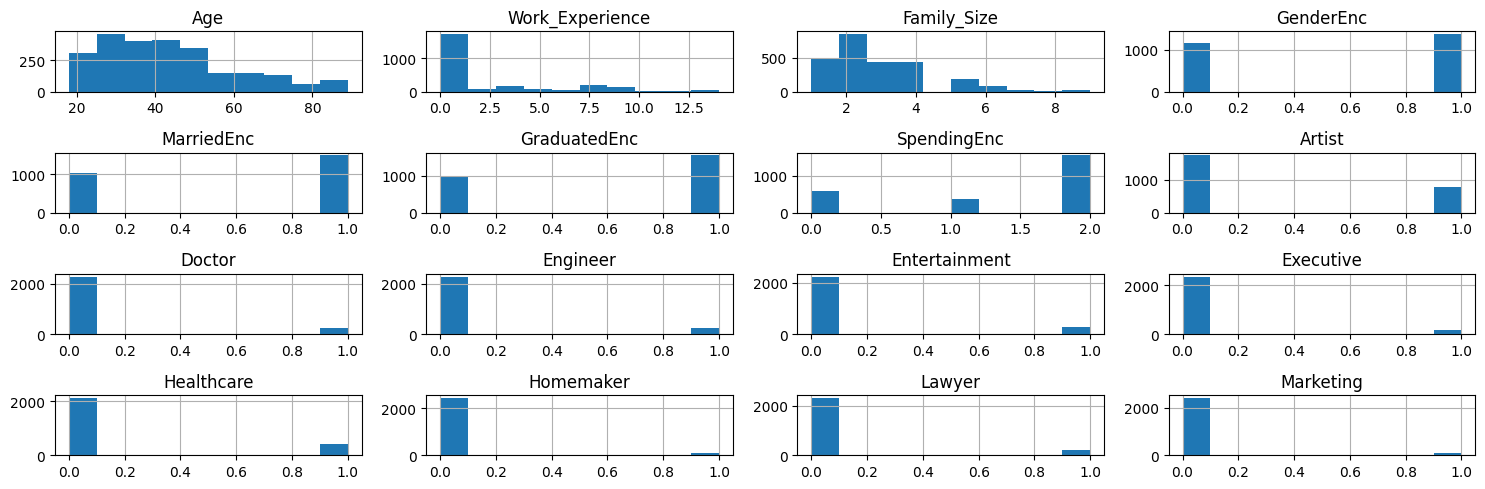

In [25]:
dfUnsupervisedML_enc2.hist(bins = 10,figsize=(15,5))
plt.tight_layout()
plt.show()

In [26]:
## Correlation Matrix
corr_mat = dfUnsupervisedML_enc2.corr()
corr_mat


,Age,Work_Experience,Family_Size,GenderEnc,MarriedEnc,GraduatedEnc,SpendingEnc,Artist,Doctor,Engineer,Entertainment,Executive,Healthcare,Homemaker,Lawyer,Marketing
Age,1.000000,-0.177749,-0.277416,-0.002418,0.577169,0.234431,-0.278714,0.100835,-0.096881,-0.053311,-0.018809,0.114915,-0.441082,-0.056468,0.573698,-0.068006
Work_Experience,-0.177749,1.000000,-0.066121,-0.064245,-0.109340,0.054506,0.072712,0.018111,-0.005130,0.004937,0.020987,-0.020757,-0.012852,0.164671,-0.114881,-0.009012
Family_Size,-0.277416,-0.066121,1.000000,0.078700,-0.079939,-0.258607,-0.107887,-0.155477,0.018342,0.024227,-0.027609,0.120760,0.225375,-0.062194,-0.158775,0.051437
GenderEnc,-0.002418,-0.064245,0.078700,1.000000,0.107500,-0.059462,-0.037533,-0.056610,-0.006621,-0.201470,0.128852,0.222794,0.072747,-0.127125,-0.035570,-0.029591
MarriedEnc,0.577169,-0.109340,-0.079939,0.107500,1.000000,0.205557,-0.614739,0.129310,-0.042910,0.024662,0.030474,0.196693,-0.420452,-0.011615,0.216324,-0.085954
GraduatedEnc,0.234431,0.054506,-0.258607,-0.059462,0.205557,1.000000,-0.144756,0.363114,0.003963,-0.094048,-0.006642,-0.054463,-0.252504,-0.032173,-0.025674,-0.104078
SpendingEnc,-0.278714,0.072712,-0.107887,-0.037533,-0.614739,-0.144756,1.000000,-0.178319,0.001248,-0.035825,-0.041482,-0.080784,0.278287,0.016025,0.010014,0.090499
Artist,0.100835,0.018111,-0.155477,-0.056610,0.129310,0.363114,-0.178319,1.000000,-0.217034,-0.212455,-0.243862,-0.181744,-0.294773,-0.121180,-0.204678,-0.142536
Doctor,-0.096881,-0.005130,0.018342,-0.006621,-0.042910,0.003963,0.001248,-0.217034,1.000000,-0.101665,-0.116694,-0.086969,-0.141056,-0.057988,-0.097944,-0.068207
Engineer,-0.053311,0.004937,0.024227,-0.201470,0.024662,-0.094048,-0.035825,-0.212455,-0.101665,1.000000,-0.114232,-0.085134,-0.138080,-0.056764,-0.095877,-0.066768


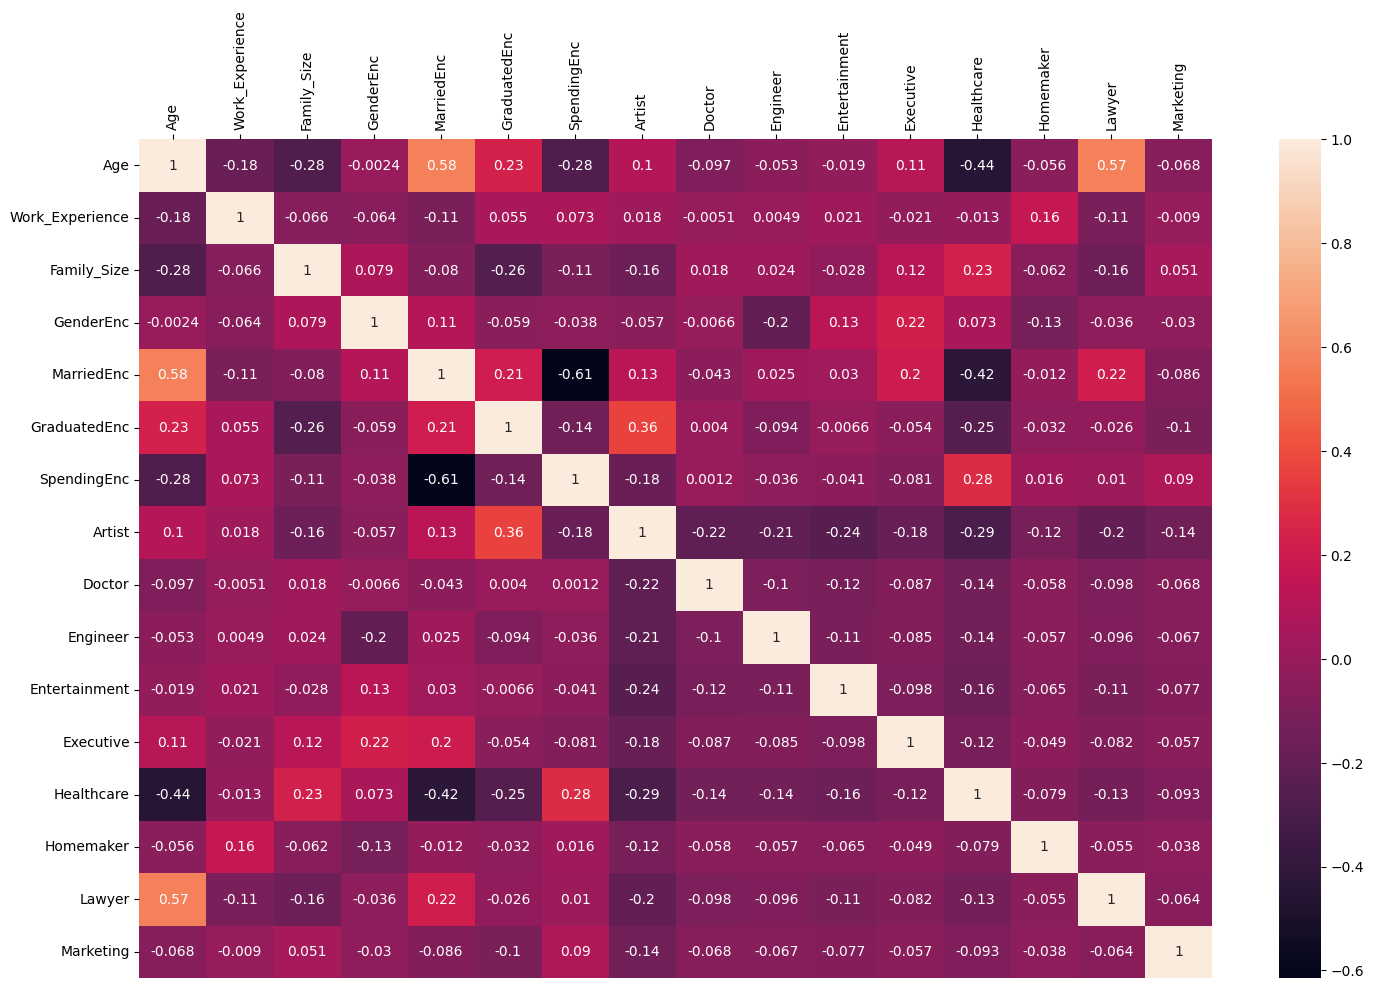

In [27]:
## visualize the correlation matrix
plt.figure(figsize=(15,10))
ax = sns.heatmap(corr_mat, annot=True)
# Move x-axis tick labels to the top
ax.xaxis.tick_top()
plt.xticks(rotation=90)
plt.tight_layout()

filename = 'corrmatrix.jpeg'
plt.savefig(filename, format = 'jpeg')
plt.show()


The fact healthcare profession is negatively correlated with age is an immediate red flag for the dataset due to the training requirements for bona fide healthcare professionals. 

This is backed up by the fact doctors are not correlated with age, but US doctors spend around 7 years in training, which is longer to train for than a lawyer. 

Same goes goes for "Executive" which would be older, experienced people but the correlation is only 0.11. 

Same goes for work experience and family size, which should have strong positive correlations with age but are weakly negatively correlated.

This dataset is unlikely to give meaningful results.

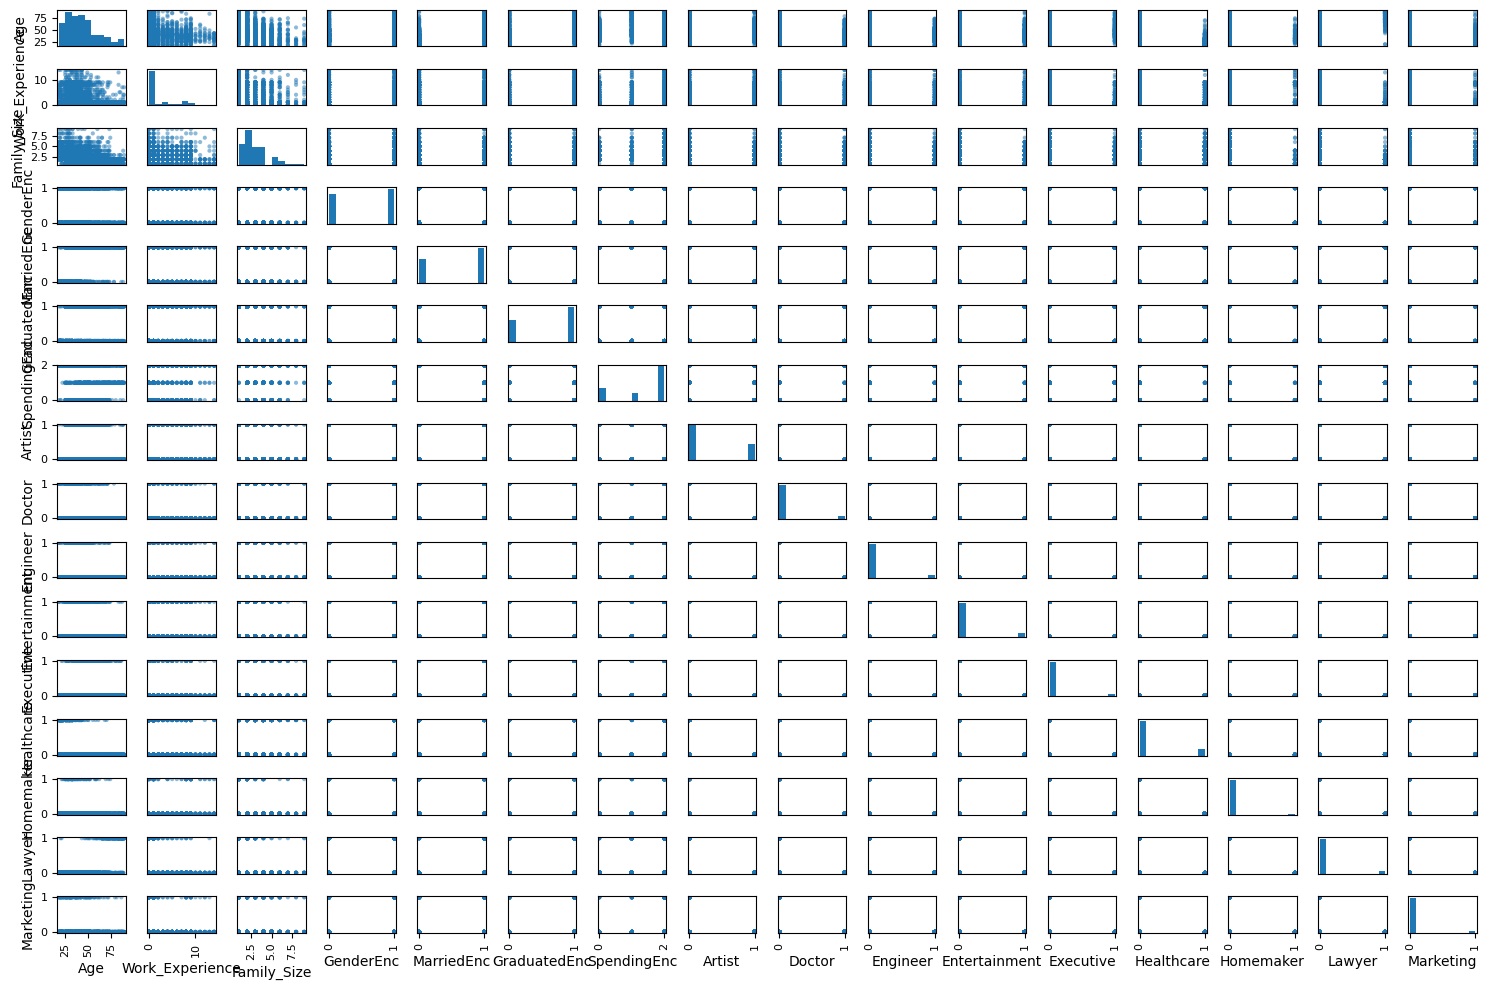

In [28]:
from pandas.plotting import scatter_matrix

scatter_matrix(dfUnsupervisedML_enc2, figsize=(15,10))
plt.tight_layout()
filename = 'scattermatrices.jpeg'
plt.savefig(filename, format = 'jpeg')
plt.show()

In [ ]:
## finding the k value using the elbow method
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k,random_state = 38)
    km.fit(dfUnsupervisedML_enc2)
    sse.append(km.inertia_)
sse


[760613.7221119493,
 269522.94483321474,
 138954.33887191908,
 99684.35429141345,
 73668.66891206484,
 60953.393419314656,
 53179.46310882483,
 46607.278337253185,
 37106.82918104388]

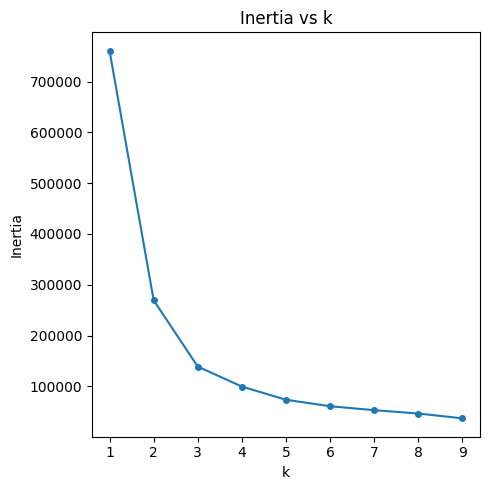

In [30]:
#plotting error rate against the k
plt.figure(figsize=(5,5))
plt.plot(k_rng,sse, marker = "o", markersize = 4)
plt.ylabel("Inertia")
plt.xlabel("k")
plt.title("Inertia vs k")
plt.tight_layout()
plt.show()

In [ ]:
# implement algorithm with k=5
# this errors out unless the index is reset after dropping nulls / nans
km = KMeans(n_clusters=5, random_state = 38)
y_pred = km.fit_predict(dfUnsupervisedML_enc2)

print("Iterations until convergence: ", km.n_iter_)
print(f"Centroids: {km.cluster_centers_}")
print("Cluster assignment ")
print(km.labels_)


Iterations until convergence:  22
Centroids: [[ 6.24169184e+01  1.34743202e+00  2.46827795e+00  6.13293051e-01
   9.51661631e-01  7.40181269e-01  1.00302115e+00  4.35045317e-01
   7.55287009e-02  4.22960725e-02  1.32930514e-01  1.11782477e-01
   1.20845921e-02  2.11480363e-02  1.38972810e-01  3.02114804e-02]
 [ 3.77768707e+01  3.47346939e+00  2.58095238e+00  4.87074830e-01
   5.46938776e-01  7.15646259e-01  1.37551020e+00  3.74149660e-01
   1.06122449e-01  1.25170068e-01  1.53741497e-01  6.66666667e-02
   9.52380952e-02  4.21768707e-02 -3.88578059e-16  3.67346939e-02]
 [ 4.87803468e+01  1.86512524e+00  2.78805395e+00  5.45279383e-01
   8.28516378e-01  7.61078998e-01  1.00000000e+00  4.85549133e-01
   7.89980732e-02  1.27167630e-01  1.25240848e-01  9.24855491e-02
   1.15606936e-02  2.69749518e-02  1.54142582e-02  3.66088632e-02]
 [ 7.92391304e+01  1.11739130e+00  1.97826087e+00  5.13043478e-01
   9.60869565e-01  6.17391304e-01  1.34782609e+00  1.13043478e-01
   1.73913043e-02  2.1739130

Hmm, not sure how to plot meaningfully with more than 3 variables (axes). Not sure where to go from here!